<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 500000 entries, 2010-01-01 to 2017-07-28
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Region          500000 non-null  object 
 1   Country         500000 non-null  object 
 2   Item Type       500000 non-null  object 
 3   Sales Channel   500000 non-null  object 
 4   Order Priority  500000 non-null  object 
 5   Order ID        500000 non-null  int64  
 6   Ship Date       500000 non-null  object 
 7   Units Sold      500000 non-null  int64  
 8   Unit Price      500000 non-null  float64
 9   Unit Cost       500000 non-null  float64
 10  Total Revenue   500000 non-null  float64
 11  Total Cost      500000 non-null  float64
 12  Total Profit    500000 non-null  float64
dtypes: float64(5), int64(2), object(6)
memory usage: 53.4+ MB
None
                                       Region      Country   Item Type  \
Order Date                               

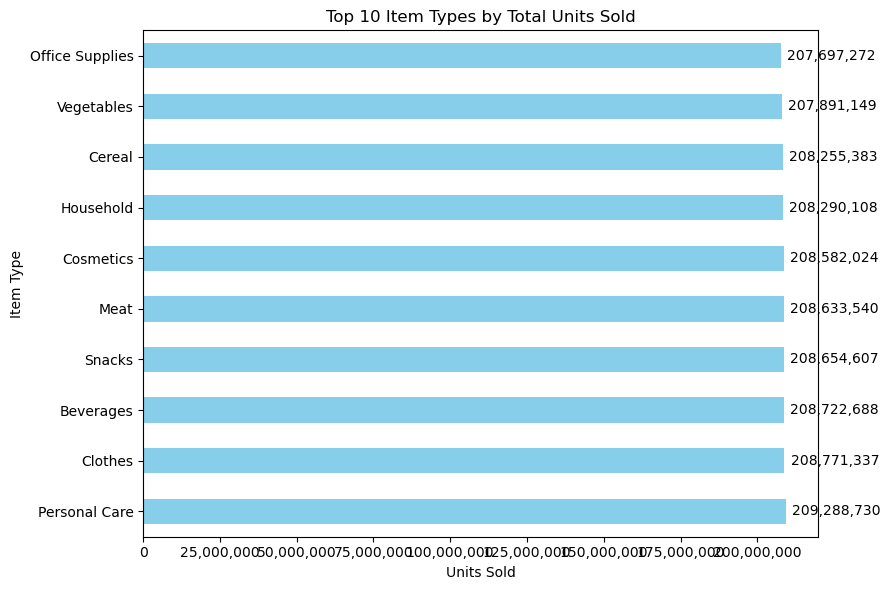

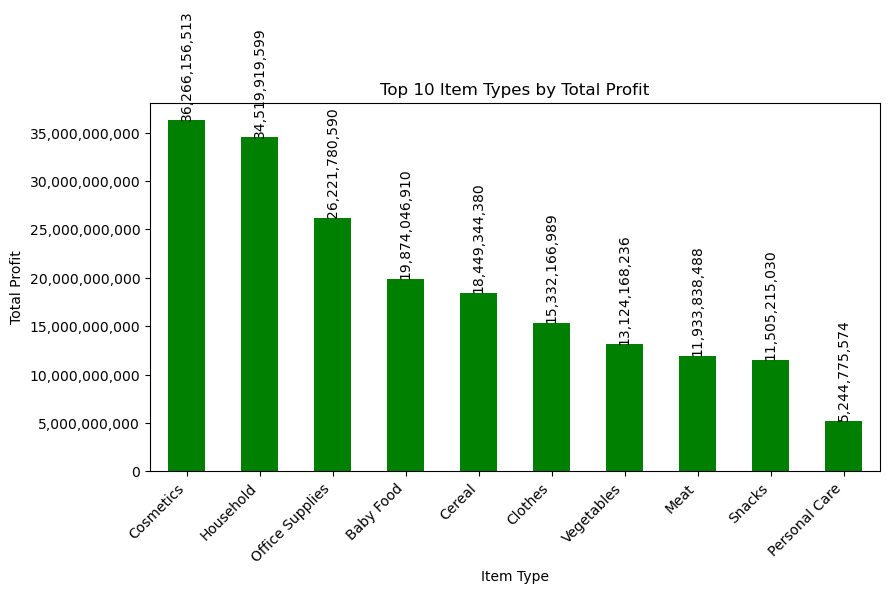

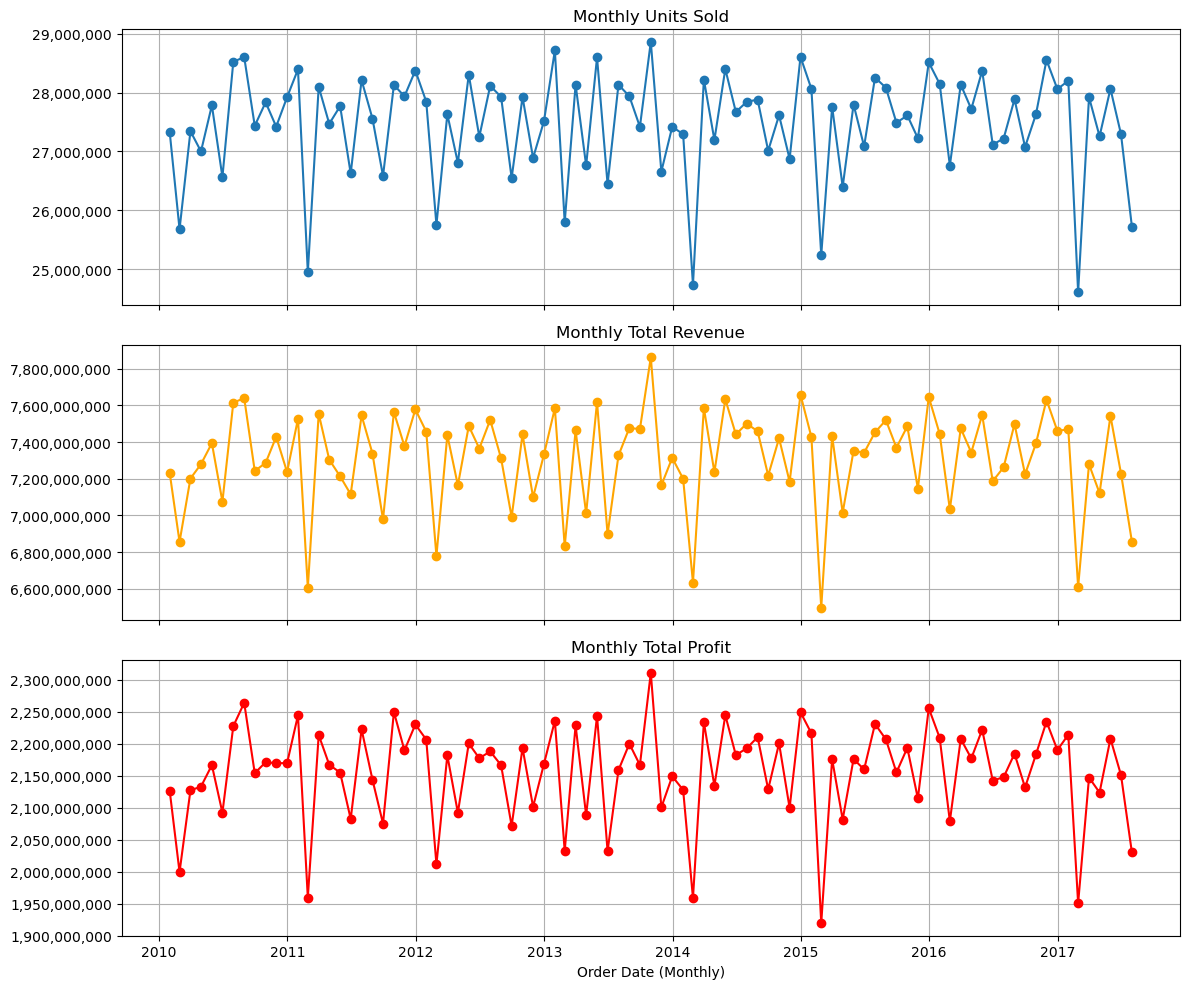

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

# ----- 1. Load and Clean the Data -----

df = pd.read_csv("arima_sales.csv")

# Convert 'Order Date' to datetime, sort, and set as index
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df.sort_values('Order Date', inplace=True)
df.set_index('Order Date', inplace=True)

print(df.info())
print(df.head())

# ----- 2. Top 10 Item Types by Total Units Sold (Horizontal Bar) -----

# Group by item type and sum units sold
top_units = (
    df.groupby("Item Type")['Units Sold']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

# Create a horizontal bar chart
fig, ax = plt.subplots(figsize=(9, 6))
top_units.plot(kind='barh', color='skyblue', ax=ax)

ax.set_title("Top 10 Item Types by Total Units Sold")
ax.set_xlabel("Units Sold")
ax.set_ylabel("Item Type")

# Format the x-axis to avoid scientific notation
ax.xaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Annotate bars with numeric values
for patch in ax.patches:
    value = patch.get_width()
    ax.annotate(
        f'{value:,.0f}',  # comma formatting
        (value + (0.01 * value), patch.get_y() + 0.5 * patch.get_height()),
        va='center'
    )

plt.tight_layout()
plt.show()

# ----- 3. Top 10 Item Types by Total Profit (Vertical Bar) -----

top_profit = (
    df.groupby("Item Type")['Total Profit']
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

fig, ax = plt.subplots(figsize=(9, 6))
top_profit.plot(kind='bar', color='green', ax=ax)

ax.set_title("Top 10 Item Types by Total Profit")
ax.set_xlabel("Item Type")
ax.set_ylabel("Total Profit")

# Format the y-axis
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# Annotate bars with numeric values
for patch in ax.patches:
    height = patch.get_height()
    ax.annotate(
        f'{height:,.0f}',
        (patch.get_x() + patch.get_width() / 2, height),
        ha='center',
        va='bottom',
        rotation=90
    )

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ----- 4. Monthly Time Series (Units Sold, Total Revenue, Total Profit) -----

# Resample monthly and sum
df_monthly = df.resample('ME').sum(numeric_only=True)

fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

# a) Monthly Units Sold
axs[0].plot(df_monthly.index, df_monthly['Units Sold'], marker='o', linestyle='-')
axs[0].set_title("Monthly Units Sold")
axs[0].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# b) Monthly Total Revenue
axs[1].plot(df_monthly.index, df_monthly['Total Revenue'], color='orange', marker='o', linestyle='-')
axs[1].set_title("Monthly Total Revenue")
axs[1].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# c) Monthly Total Profit
axs[2].plot(df_monthly.index, df_monthly['Total Profit'], color='red', marker='o', linestyle='-')
axs[2].set_title("Monthly Total Profit")
axs[2].yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

for ax in axs:
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.grid(True)

axs[2].set_xlabel("Order Date (Monthly)")

plt.tight_layout()
plt.show()



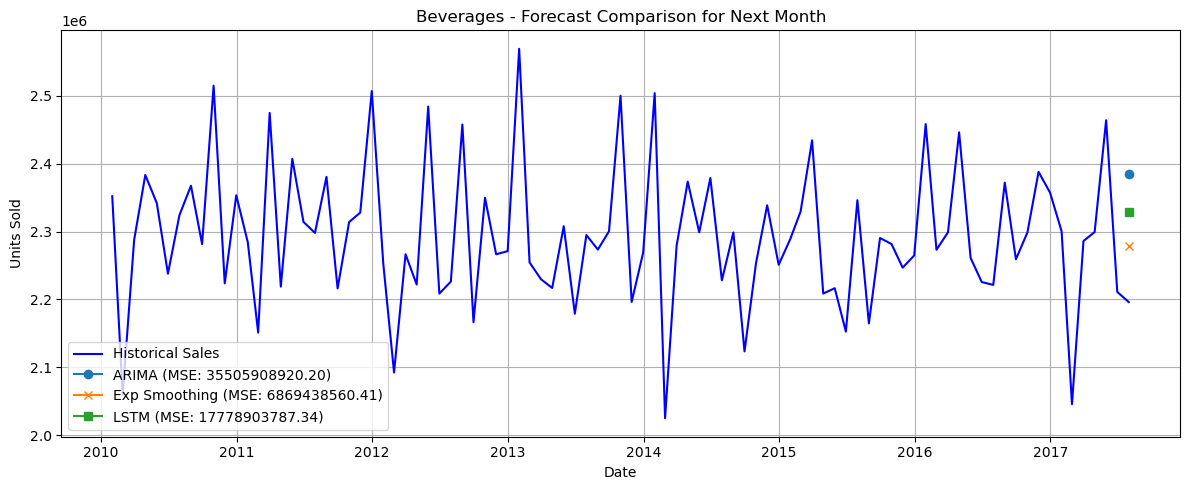

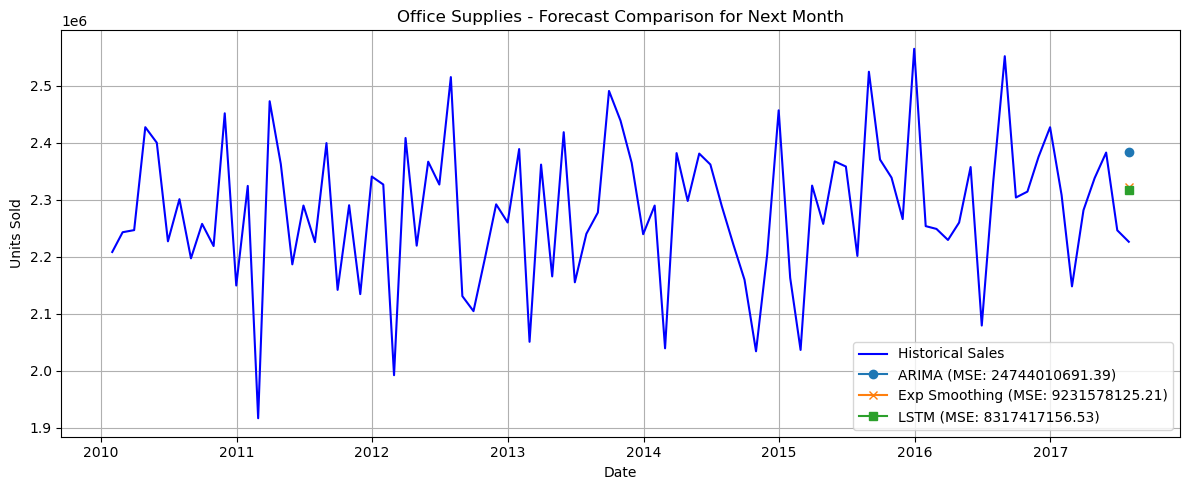

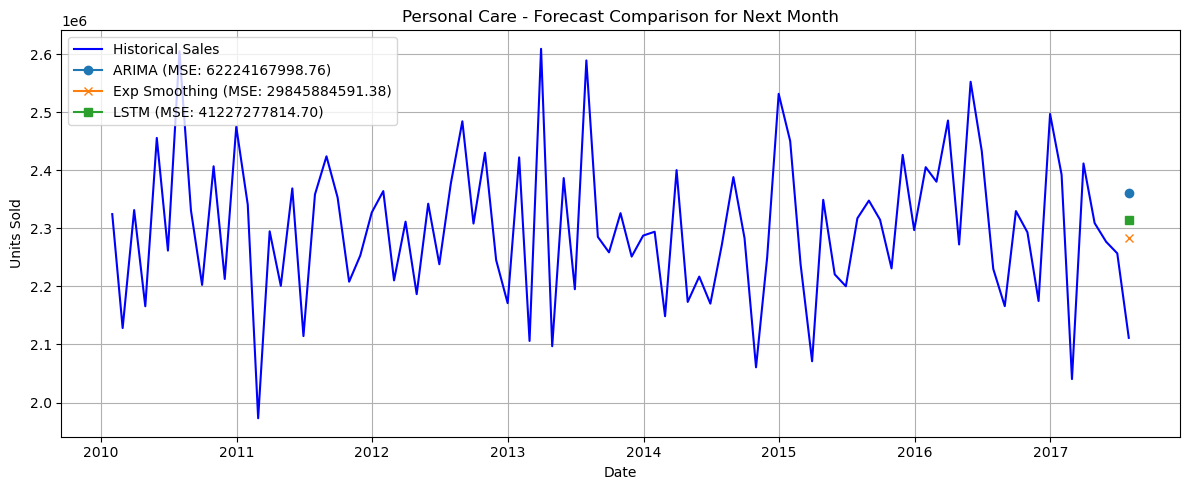

In [28]:
# Top Performers (Suggest Restock)
# ARIMA Plots with Exp Smoothing and LSTM Comparisons (MSE Included)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow retracing warnings

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# Load dataset
df = pd.read_csv("arima_sales.csv")
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Create monthly sales matrix
monthly_sales = df.groupby([pd.Grouper(key='Order Date', freq='M'), 'Item Type'])['Units Sold'].sum().unstack().fillna(0)

# --- Function Definitions ---

def optimize_arima_order_pct(series, p_range=4, q_range=4):
    p = q = range(0, p_range)
    combinations = list(itertools.product(p, q))
    best_aic = float("inf")
    best_order = None
    for order in combinations:
        try:
            model = ARIMA(series, order=(order[0], 0, order[1]))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (order[0], 0, order[1])
        except:
            continue
    return best_order

def forecast_arima_pct(series):
    pct_series = series.pct_change().dropna()
    order = optimize_arima_order_pct(pct_series)
    model = ARIMA(pct_series, order=order)
    model_fit = model.fit()
    forecast_pct = model_fit.forecast(steps=1).iloc[0]
    forecast = series.iloc[-1] * (1 + forecast_pct)
    return max(0, forecast), model_fit, order

def forecast_exponential_smoothing(series):
    model = ExponentialSmoothing(series, trend='add', seasonal=None).fit()
    forecast = model.forecast(1).iloc[0]
    return forecast, model

def forecast_lstm(series, window=12):
    scaler = MinMaxScaler()
    scaled_series = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

    def create_sequences(data):
        x, y = [], []
        for i in range(len(data) - window):
            x.append(data[i:i+window])
            y.append(data[i+window])
        return np.array(x), np.array(y)

    X, y = create_sequences(scaled_series)
    if len(X) == 0:
        return series.iloc[-1], None  # fallback for short series

    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential([
        LSTM(50, input_shape=(X.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, batch_size=8, verbose=0, callbacks=[EarlyStopping(patience=10)])

    lstm_input = scaled_series[-window:].reshape(1, window, 1)
    forecast_scaled = model.predict(lstm_input, verbose=0)[0, 0]
    forecast = scaler.inverse_transform([[forecast_scaled]])[0, 0]
    return max(0, forecast), model

# --- Forecast All Items ---

forecasts = {}
for item in monthly_sales.columns:
    series = monthly_sales[item]
    try:
        arima_pred, arima_model, arima_order = forecast_arima_pct(series)
        exp_pred, exp_model = forecast_exponential_smoothing(series)
        lstm_pred, lstm_model = forecast_lstm(series)

        y_true = [series.iloc[-1]]
        arima_mse = mean_squared_error(y_true, [arima_pred])
        exp_mse = mean_squared_error(y_true, [exp_pred])
        lstm_mse = mean_squared_error(y_true, [lstm_pred])

        forecasts[item] = {
            'series': series,
            'arima_pred': arima_pred,
            'exp_pred': exp_pred,
            'lstm_pred': lstm_pred,
            'mse': {
                'ARIMA': arima_mse,
                'ExpSmooth': exp_mse,
                'LSTM': lstm_mse
            }
        }
    except Exception as e:
        print(f"Skipped {item} due to error: {e}")
        continue

# Plot the 3 highest ARIMA forecasts
top_3 = sorted(forecasts.items(), key=lambda x: x[1]['arima_pred'], reverse=True)[:3]

for item, data in top_3:
    series = data['series']
    forecast_date = series.index[-1] + pd.offsets.MonthBegin()

    plt.figure(figsize=(12, 5))
    plt.plot(series.index, series, label='Historical Sales', color='blue')
    plt.plot(forecast_date, data['arima_pred'], marker='o', label=f"ARIMA (MSE: {data['mse']['ARIMA']:.2f})")
    plt.plot(forecast_date, data['exp_pred'], marker='x', label=f"Exp Smoothing (MSE: {data['mse']['ExpSmooth']:.2f})")
    plt.plot(forecast_date, data['lstm_pred'], marker='s', label=f"LSTM (MSE: {data['mse']['LSTM']:.2f})")

    plt.title(f"{item} - Forecast Comparison for Next Month")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


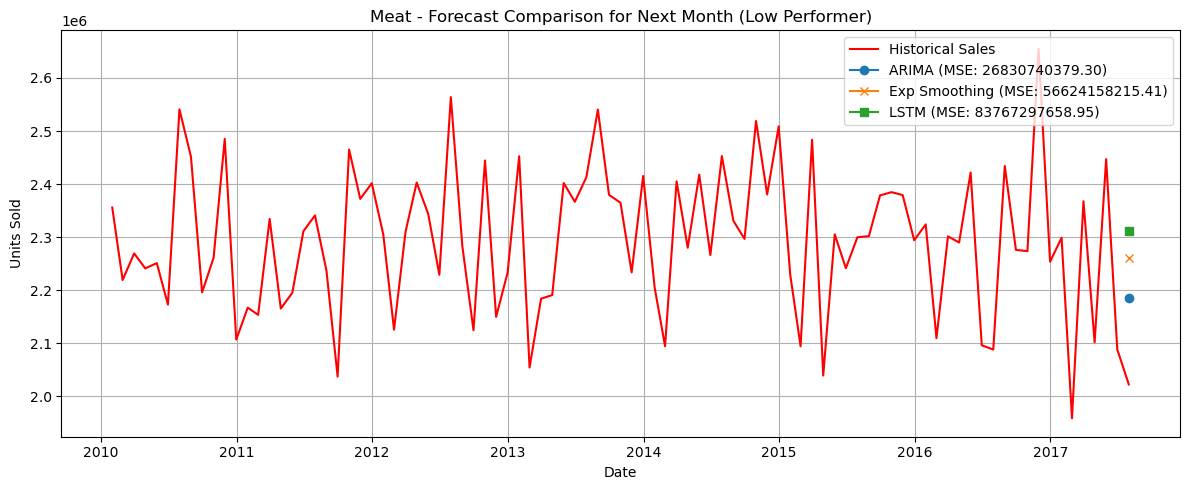

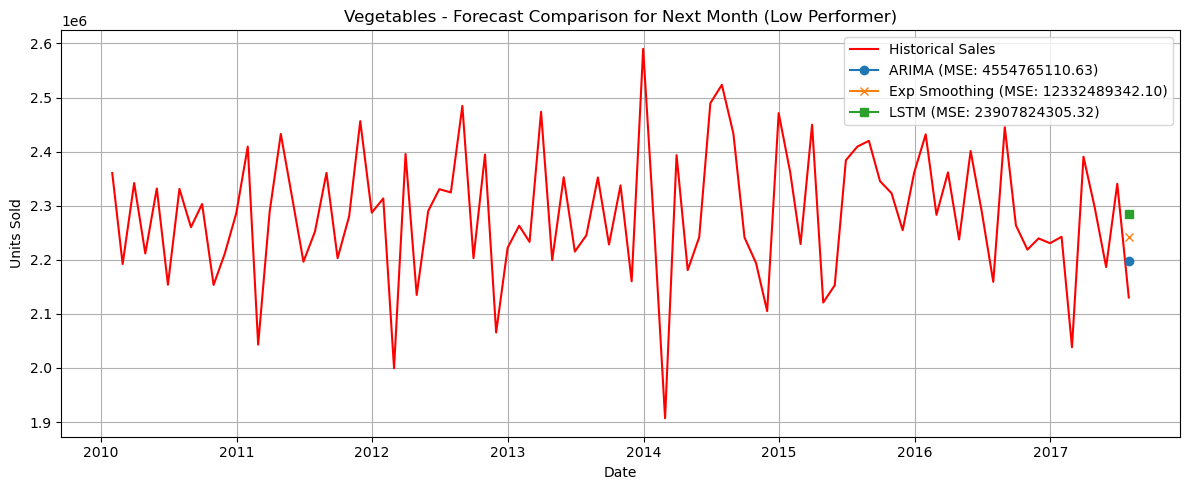

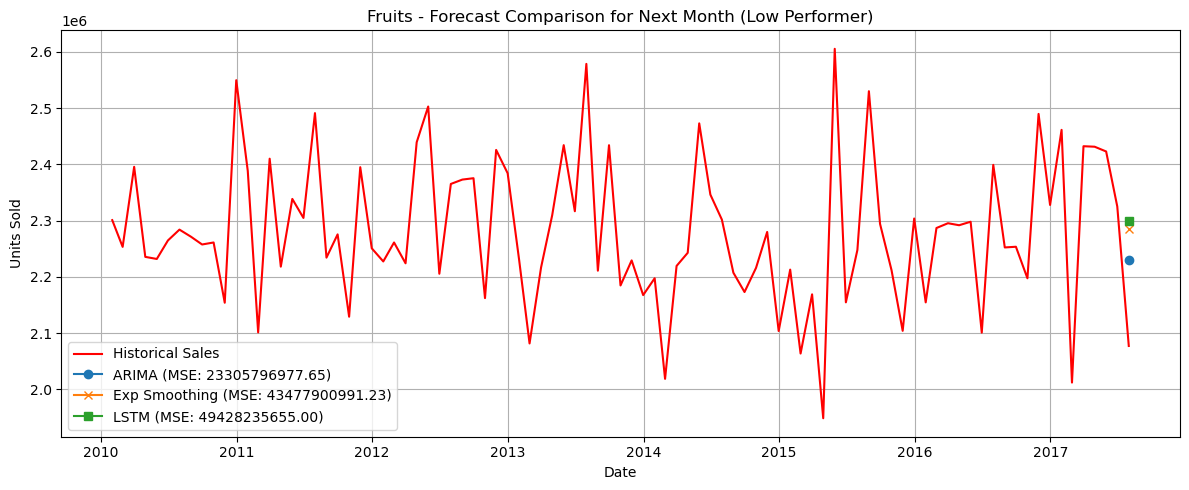

In [29]:
# Low Performers (Suggest Removal)
# ARIMA Plots with Exp Smoothing and LSTM Comparisons (MSE Included)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

df = pd.read_csv("arima_sales.csv")
df['Order Date'] = pd.to_datetime(df['Order Date'])

monthly_sales = df.groupby([pd.Grouper(key='Order Date', freq='M'), 'Item Type'])['Units Sold'].sum().unstack().fillna(0)

def optimize_arima_order_pct(series, p_range=4, q_range=4):
    p = q = range(0, p_range)
    combinations = list(itertools.product(p, q))
    best_aic = float("inf")
    best_order = None
    for order in combinations:
        try:
            model = ARIMA(series, order=(order[0], 0, order[1]))
            results = model.fit()
            if results.aic < best_aic:
                best_aic = results.aic
                best_order = (order[0], 0, order[1])
        except:
            continue
    return best_order

def forecast_arima_pct(series):
    pct_series = series.pct_change().dropna()
    order = optimize_arima_order_pct(pct_series)
    model = ARIMA(pct_series, order=order)
    model_fit = model.fit()
    forecast_pct = model_fit.forecast(steps=1).iloc[0]
    forecast = series.iloc[-1] * (1 + forecast_pct)
    return max(0, forecast), model_fit, order

def forecast_exponential_smoothing(series):
    model = ExponentialSmoothing(series, trend='add', seasonal=None).fit()
    forecast = model.forecast(1).iloc[0]
    return forecast, model

def forecast_lstm(series, window=12):
    scaler = MinMaxScaler()
    scaled_series = scaler.fit_transform(series.values.reshape(-1, 1)).flatten()

    def create_sequences(data):
        x, y = [], []
        for i in range(len(data) - window):
            x.append(data[i:i+window])
            y.append(data[i+window])
        return np.array(x), np.array(y)

    X, y = create_sequences(scaled_series)
    if len(X) == 0:
        return series.iloc[-1], None

    X = X.reshape((X.shape[0], X.shape[1], 1))

    model = Sequential([
        LSTM(50, input_shape=(X.shape[1], 1)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=100, batch_size=8, verbose=0, callbacks=[EarlyStopping(patience=10)])

    lstm_input = scaled_series[-window:].reshape(1, window, 1)
    forecast_scaled = model.predict(lstm_input, verbose=0)[0, 0]
    forecast = scaler.inverse_transform([[forecast_scaled]])[0, 0]
    return max(0, forecast), model

forecasts = {}
for item in monthly_sales.columns:
    series = monthly_sales[item]
    try:
        arima_pred, arima_model, arima_order = forecast_arima_pct(series)
        exp_pred, exp_model = forecast_exponential_smoothing(series)
        lstm_pred, lstm_model = forecast_lstm(series)

        y_true = [series.iloc[-1]]
        arima_mse = mean_squared_error(y_true, [arima_pred])
        exp_mse = mean_squared_error(y_true, [exp_pred])
        lstm_mse = mean_squared_error(y_true, [lstm_pred])

        forecasts[item] = {
            'series': series,
            'arima_pred': arima_pred,
            'exp_pred': exp_pred,
            'lstm_pred': lstm_pred,
            'mse': {
                'ARIMA': arima_mse,
                'ExpSmooth': exp_mse,
                'LSTM': lstm_mse
            }
        }
    except Exception as e:
        print(f"Skipped {item} due to error: {e}")
        continue

# Plot the 3 lowest ARIMA forecasts
bottom_3 = sorted(forecasts.items(), key=lambda x: x[1]['arima_pred'])[:3]

for item, data in bottom_3:
    series = data['series']
    forecast_date = series.index[-1] + pd.offsets.MonthBegin()

    plt.figure(figsize=(12, 5))
    plt.plot(series.index, series, label='Historical Sales', color='red')
    plt.plot(forecast_date, data['arima_pred'], marker='o', label=f"ARIMA (MSE: {data['mse']['ARIMA']:.2f})")
    plt.plot(forecast_date, data['exp_pred'], marker='x', label=f"Exp Smoothing (MSE: {data['mse']['ExpSmooth']:.2f})")
    plt.plot(forecast_date, data['lstm_pred'], marker='s', label=f"LSTM (MSE: {data['mse']['LSTM']:.2f})")

    plt.title(f"{item} - Forecast Comparison for Next Month (Low Performer)")
    plt.xlabel("Date")
    plt.ylabel("Units Sold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()